In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow

In [30]:
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import torchvision.transforms as transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import optim
from torchvision.ops import sigmoid_focal_loss as fc_loss
from random import shuffle
from keras.preprocessing.image import ImageDataGenerator
import torch.nn.init as init
import random

In [31]:
def upsampleing_image(original_img_path, outdir, n_gen):
  #function to upsampling images
  #original_img_path: dir to your original images
  #outdir: dir where new generated images will be saved
  #n_gen: number of new sample per each image
  datagen = ImageDataGenerator(
          rotation_range=20,
          width_shift_range=0.1,
          height_shift_range=0.1,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')
  ori_images = os.listdir(original_img_path)
  for ori_img in ori_images:
    img_path = os.path.join(original_img_path, ori_img)
    image = Image.open(img_path)  # this is a PIL image
    resized_image = image.resize((256, 256))
    x = np.array(resized_image)
    x = x.reshape((1,) + x.shape)

    # the .flow() command below generates batches of randomly transformed images
    # and saves the results to the `preview/` directory
    i = 1
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir=outdir, save_prefix='field', save_format='jpg'):
        i += 1
        if i > n_gen:
            break  # otherwise the generator would loop indefinitely

In [32]:
# indir = '/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Train/roads'
# outdir = '/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Train/gen_roads'
# upsampleing_image(indir,outdir, 2)

In [33]:
def create_dataset(train_dir, out_db_dir, out_label_dir):
  #function to convert images dataset to txt file for later use
  #train_dir: dir to training images
  #out_db_dir: dir where new image tensor will be saved
  #out_label_dir: dir where label tensor will be saved
  folders = os.listdir(train_dir)
  imagelist = []
  labellist = []
  folders = [fol for fol in folders if "txt" not in fol]
  for fol in folders:
    if "roads" in fol:
      label = 0
    else:
      label = 1
    fol_path = os.path.join(train_dir, fol)
    images = os.listdir(fol_path)
    images = [os.path.join(fol_path, image) for image in images]
    fol_label = [label for _ in range(len(images))]
    imagelist += images
    labellist += fol_label

  assert len(imagelist) == len(labellist)

  combined = list(zip(imagelist, labellist))
  shuffle(combined)
  shuffled_image, shuffled_label = zip(*combined)
  imagelist = []
  labellist = []
  for i in range(len(shuffled_image)):
    image_path = shuffled_image[i]
    try:
      # Open the image using Pillow
      image = Image.open(image_path)
      # Convert the image to a NumPy array
      resized_image = image.resize((128, 128))
      image_array = np.array(resized_image)
      imagelist.append(image_array)
      labellist.append(shuffled_label[i])
    except:
      print("can not open image")
  assert len(imagelist) == len(labellist)
  batch = np.stack(imagelist, axis=0)
  flattened_data = batch.ravel()
  np.savetxt(out_db_dir, flattened_data, fmt='%d', delimiter=',')
  np.savetxt(out_label_dir, labellist, fmt='%d', delimiter=',')

In [34]:
traindir = "/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Train"
out_db_dir = '/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Train/db_train_128.txt'
out_label_dir = '/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Train/db_train_label_128.txt'
# create_dataset(traindir, out_db_dir, out_label_dir)

In [35]:
labels = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Train/db_train_label.txt', delimiter=',')
print(list(labels).count(0))
print(list(labels).count(1))

321
267


In [36]:
loaded_array = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Train/db_train_128.txt', delimiter=',')
# Reshape the loaded data back to its original 4D shape
loaded_array = loaded_array.reshape((588, 128, 128, 3))

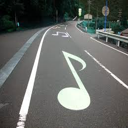

In [37]:
import cv2
from google.colab.patches import cv2_imshow
cv2_imshow(loaded_array[12])

In [38]:
class myDataseTest(Dataset):
  def __init__(self, data, labels, transform = None):
    super(myDataseTest, self).__init__()
    self.transform = transform if transform != None else transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5])
    self.images = data
    self.labels = labels

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image = self.images[index]
    image = image.astype(np.uint8)
    image = self.transform(image)
    label = float(self.labels[index])
    return image, label

In [39]:
class myDataLoader():
  #class return traindataloader and validationloader
  def __init__(self, train_dir, train_label_dir, transform = None):
    self.transform = transform if transform != None else transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean = 0.5, std = 0.5])
    self.images, self.labels = self.loadTrainSample(train_dir,train_label_dir)

  def loadTrainSample(self, trainimgdir, trainlabledir):
    labels = np.loadtxt(trainlabledir, delimiter=',')
    loaded_flattened_data = np.loadtxt(trainimgdir, delimiter=',')
    # Reshape the loaded data back to its original 4D shape
    db_train = loaded_flattened_data.reshape((588, 128, 128, 3))
    db_train = db_train.astype(np.float32)
    labels = list(labels)

    assert db_train.shape[0] == len(labels)
    print(labels.count(1))
    print(labels.count(0))
    return db_train, labels

  def getTestsetlen(self):
    return self.labels.count('0'), self.labels.count('1')

  def getDataLoader(self):
    datalen = len(self.labels)
    train_len = int((datalen/5)*4) #80%


    data_train = self.images[0:train_len]
    label_train = self.labels[0:train_len]
    data_valid = self.images[train_len+1:]
    label_valid = self.labels[train_len+1:]

    assert data_train.shape[0] == len(label_train)
    assert data_valid.shape[0] == len(label_valid)

    datatrain = myDataseTest(data_train, label_train)
    datavalidation = myDataseTest(data_valid, label_valid)

    train_loader = DataLoader(
    datatrain,
    batch_size=BATCH_SIZE_VALIDATION,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    )

    validation_loader = DataLoader(
    datavalidation,
    batch_size=BATCH_SIZE_TRAINING,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    )
    return train_loader, validation_loader


In [40]:
LEARNING_RATE = 1e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE_VALIDATION = 16
BATCH_SIZE_TRAINING = 16
NUM_EPOCHS = 30
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
train_db_dir = '/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Train/db_train_128.txt'
train_label_dir = '/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Train/db_train_label_128.txt'

In [41]:
mydataloader = myDataLoader(train_db_dir, train_label_dir)
trainloader, valid_loader = mydataloader.getDataLoader()


267
321


In [42]:
class MyModel(nn.Module):
    def __init__(self, inputchannel = 3, output_channel = 1):
        super(MyModel, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=inputchannel,
                out_channels=32,
                kernel_size=7,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32,
                      out_channels=64,
                      kernel_size=5,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=5,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.dropout = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()

        self.dense1 = nn.Linear(128*12*12, 128)
        self.dense2 = nn.Linear(128, 1)

        self.initialize_weights()
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.dense2(x)
        return x    # return x for visualization

    def initialize_weights(self):
        print("init model")
        for module in self.modules():
            if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
                # Use Xavier/Glorot initialization for weights
                init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    init.zeros_(module.bias)

In [43]:
model = MyModel().to(device=DEVICE)

init model


In [44]:
optimizer = optim.Adam(model.parameters(), lr= LEARNING_RATE)
loss_fn = nn.BCEWithLogitsLoss()

In [45]:
def train(model, issave = False, savepath = ''):
  #function to train model
  train_losses = []
  validate_losses = []
  sigmmmoid = nn.Sigmoid()
  if issave == True:
    PATH = savepath
    model.load_state_dict(torch.load(PATH))
  for epochs in range(NUM_EPOCHS):
    epoch_loss = 0
    running_vloss = 0
    model.train()
    loop = tqdm(trainloader)
    for batch_idx, (data, label) in enumerate(loop):
        data = data.to(device=DEVICE)
        label = np.asarray(label).reshape(data.shape[0], 1)
        label = torch.Tensor(label).to(device = DEVICE)
        # forward
        predictions = model(data)
        loss = loss_fn(predictions, label)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
        epoch_loss += loss.item()
    train_losses.append(epoch_loss/batch_idx)

    # validation
    model.eval()
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for batch_idx, vdata in enumerate(valid_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.to(device=DEVICE)
        vlabels = np.asarray(vlabels).reshape(vinputs.shape[0], 1)
        vlabels = torch.Tensor(vlabels).to(device = DEVICE)
        with torch.no_grad():
          voutputs = model(vinputs)

        voutputs_P =  sigmmmoid(voutputs)
        voutputs_P = voutputs_P.squeeze()

        vlabels_P = vlabels.squeeze()

        FP += torch.sum((voutputs_P >= 0.5) & (vlabels_P == 0)).item()
        TP += torch.sum((voutputs_P >= 0.5) & (vlabels_P == 1)).item()
        FN += torch.sum((voutputs_P < 0.5) & (vlabels_P == 1)).item()
        TN += torch.sum((voutputs_P < 0.5) & (vlabels_P == 0)).item()
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss.item()
    validate_losses.append(running_vloss/batch_idx)
    print("\n FP", FP)
    print("\n TP", TP)
    print("\n FN", FN)
    print("\n TN", TN)
    FAR = FP/(FP + TN+1)
    FRR = FN/(FN + TP+1)
    print("\n error", (FAR + FRR)/2)


    print('save model')
    torch.save(model.state_dict(), savepath)
  return train_losses, validate_losses

In [46]:
save_dir = "/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Weights/weight.pth"

In [47]:
train_losses, validate_losses = train(model, issave = False, savepath=save_dir)

100%|██████████| 30/30 [00:00<00:00, 34.47it/s, loss=0.641]



 FP 0

 TP 17

 FN 33

 TN 67

 error 0.3235294117647059
save model


100%|██████████| 30/30 [00:00<00:00, 38.17it/s, loss=0.725]



 FP 15

 TP 47

 FN 3

 TN 52

 error 0.13970588235294118
save model


100%|██████████| 30/30 [00:00<00:00, 38.83it/s, loss=0.108]



 FP 6

 TP 43

 FN 7

 TN 61

 error 0.1127450980392157
save model


100%|██████████| 30/30 [00:00<00:00, 37.64it/s, loss=0.379]



 FP 5

 TP 44

 FN 6

 TN 62

 error 0.09558823529411764
save model


100%|██████████| 30/30 [00:00<00:00, 36.68it/s, loss=0.0145]



 FP 3

 TP 40

 FN 10

 TN 64

 error 0.12009803921568628
save model


100%|██████████| 30/30 [00:00<00:00, 39.07it/s, loss=0.26]



 FP 3

 TP 40

 FN 10

 TN 64

 error 0.12009803921568628
save model


100%|██████████| 30/30 [00:00<00:00, 33.09it/s, loss=0.231]



 FP 2

 TP 42

 FN 8

 TN 65

 error 0.09313725490196079
save model


100%|██████████| 30/30 [00:01<00:00, 21.60it/s, loss=0.37]



 FP 1

 TP 41

 FN 9

 TN 66

 error 0.09558823529411765
save model


100%|██████████| 30/30 [00:01<00:00, 18.07it/s, loss=0.114]



 FP 4

 TP 45

 FN 5

 TN 63

 error 0.0784313725490196
save model


100%|██████████| 30/30 [00:00<00:00, 38.69it/s, loss=0.129]



 FP 1

 TP 42

 FN 8

 TN 66

 error 0.0857843137254902
save model


100%|██████████| 30/30 [00:00<00:00, 38.29it/s, loss=0.0238]



 FP 5

 TP 48

 FN 2

 TN 62

 error 0.056372549019607844
save model


100%|██████████| 30/30 [00:00<00:00, 36.08it/s, loss=0.245]



 FP 5

 TP 47

 FN 3

 TN 62

 error 0.0661764705882353
save model


100%|██████████| 30/30 [00:00<00:00, 38.12it/s, loss=0.205]



 FP 4

 TP 48

 FN 2

 TN 63

 error 0.049019607843137254
save model


100%|██████████| 30/30 [00:00<00:00, 36.52it/s, loss=0.037]



 FP 4

 TP 48

 FN 2

 TN 63

 error 0.049019607843137254
save model


100%|██████████| 30/30 [00:00<00:00, 37.75it/s, loss=0.0483]



 FP 3

 TP 47

 FN 3

 TN 64

 error 0.051470588235294115
save model


100%|██████████| 30/30 [00:00<00:00, 35.13it/s, loss=0.223]



 FP 4

 TP 47

 FN 3

 TN 63

 error 0.058823529411764705
save model


100%|██████████| 30/30 [00:00<00:00, 39.07it/s, loss=0.00468]



 FP 1

 TP 45

 FN 5

 TN 66

 error 0.056372549019607844
save model


100%|██████████| 30/30 [00:01<00:00, 27.35it/s, loss=0.0835]



 FP 4

 TP 48

 FN 2

 TN 63

 error 0.049019607843137254
save model


100%|██████████| 30/30 [00:01<00:00, 26.03it/s, loss=0.0105]



 FP 4

 TP 48

 FN 2

 TN 63

 error 0.049019607843137254
save model


100%|██████████| 30/30 [00:01<00:00, 26.37it/s, loss=0.0537]



 FP 4

 TP 47

 FN 3

 TN 63

 error 0.058823529411764705
save model


100%|██████████| 30/30 [00:00<00:00, 38.97it/s, loss=0.168]



 FP 4

 TP 48

 FN 2

 TN 63

 error 0.049019607843137254
save model


100%|██████████| 30/30 [00:00<00:00, 35.51it/s, loss=0.00992]



 FP 4

 TP 50

 FN 0

 TN 63

 error 0.029411764705882353
save model


100%|██████████| 30/30 [00:00<00:00, 35.87it/s, loss=0.0266]



 FP 1

 TP 47

 FN 3

 TN 66

 error 0.03676470588235294
save model


100%|██████████| 30/30 [00:00<00:00, 37.86it/s, loss=0.029]



 FP 5

 TP 48

 FN 2

 TN 62

 error 0.056372549019607844
save model


100%|██████████| 30/30 [00:00<00:00, 39.02it/s, loss=0.0226]



 FP 1

 TP 48

 FN 2

 TN 66

 error 0.02696078431372549
save model


100%|██████████| 30/30 [00:00<00:00, 37.93it/s, loss=0.0309]



 FP 3

 TP 49

 FN 1

 TN 64

 error 0.031862745098039214
save model


100%|██████████| 30/30 [00:00<00:00, 35.79it/s, loss=0.0957]



 FP 1

 TP 48

 FN 2

 TN 66

 error 0.02696078431372549
save model


100%|██████████| 30/30 [00:00<00:00, 37.66it/s, loss=0.0124]



 FP 1

 TP 48

 FN 2

 TN 66

 error 0.02696078431372549
save model


100%|██████████| 30/30 [00:00<00:00, 32.91it/s, loss=0.195]



 FP 5

 TP 48

 FN 2

 TN 62

 error 0.056372549019607844
save model


100%|██████████| 30/30 [00:01<00:00, 27.39it/s, loss=0.0236]



 FP 1

 TP 47

 FN 3

 TN 66

 error 0.03676470588235294
save model


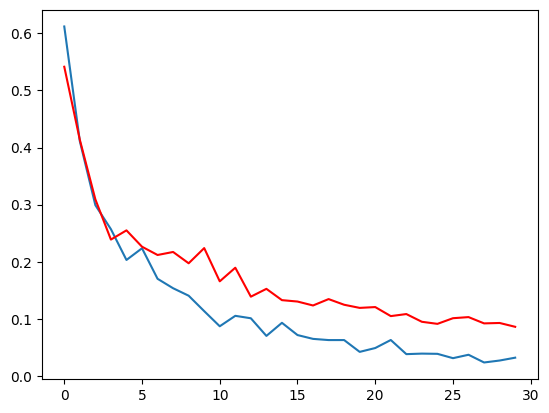

In [48]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.plot(validate_losses, 'r')
plt.show()

/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Test/2.jpeg


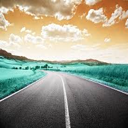

prediction is :  tensor([[0.0079]], device='cuda:0')
/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Test/1.jpeg


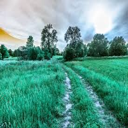

prediction is :  tensor([[0.9985]], device='cuda:0')
/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Test/3.jpeg


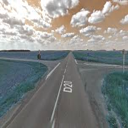

prediction is :  tensor([[0.0057]], device='cuda:0')
/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Test/7.jpeg


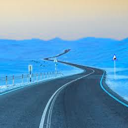

prediction is :  tensor([[0.7924]], device='cuda:0')
/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Test/8.jpeg


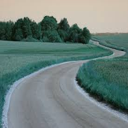

prediction is :  tensor([[0.0248]], device='cuda:0')
/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Test/10.jpeg


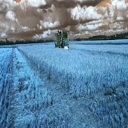

prediction is :  tensor([[0.9961]], device='cuda:0')
/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Test/9.jpeg


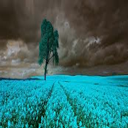

prediction is :  tensor([[0.9836]], device='cuda:0')
/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Test/4.jpeg


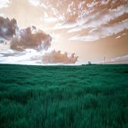

prediction is :  tensor([[0.4566]], device='cuda:0')
/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Test/5.jpeg


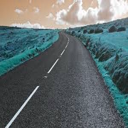

prediction is :  tensor([[0.1810]], device='cuda:0')
/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Test/6.jpeg


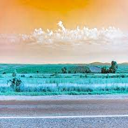

prediction is :  tensor([[0.5014]], device='cuda:0')


In [49]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/Road_field_classification/Dataset/Test'

files = os.listdir(test_dir)

idx = random.randint(0, len(files)-1)
image_dir = files[idx]
for image_dir in files:
  testimgdir = os.path.join(test_dir, image_dir)


  transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),]) # mean = 0.5, std = 0.5])

  print(testimgdir)

  # Open the image using Pillow
  image = Image.open(testimgdir)
  # Convert the image to a NumPy array
  resized_image = image.resize((128, 128))
  image_array = np.array(resized_image)
  cv2_imshow(image_array)

  test_image = transform(image_array)
  test_image = test_image[None,:, :, :].to(device = 'cuda')


  with torch.no_grad():
    prediction = model(test_image)
    sigmmmoid = nn.Sigmoid()
    P = sigmmmoid(prediction)
    print("prediction is : ",P)




In [50]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 2620929
